# Visualização e Classificação de Falhas em Equipamento

O Objetivo principal é a criação de um modelo que possa nos auxiliar na prevenção de falhas em equipamentos presente em FPSO. Para isso serão analisados dads provenientes de sensores que fazem medição de propriedades físicas do equipamento de acordo com dois tipos de configurações de setup.



### Primeiramente vamos importar as bibliotecas que serão utilizadas na análise.

As bibliotecas foram separadas de duas formas, bibliotecas de carregamento de dados e visualização gráfica e bibliotecas de Machine Learning.

In [185]:
#Importação de bibliotecas para carregar dados e visualiza-los
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


In [45]:
# Bibliotecas para Machine Learning
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

Primeiramente vamos carregar o arquivo que contém os dados a serem analisados

In [3]:
fpso_df = pd.read_excel('O_G_Equipment_Data.xlsx')
fpso_df

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False
...,...,...,...,...,...,...,...,...,...,...
795,796,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,True
796,797,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,True
797,798,1,4,79.777294,110.535405,61.334995,149.577811,129.463843,70.853353,True
798,799,2,8,79.360314,159.985443,61.762879,169.773831,130.213426,80.113540,True


Algo que podemos verificar de imediato é que a coluna de falhas está como False/True, ou seja, é do tipo booleana. Vamos então transformá-la para o tipo inteiro, de forma que seja mais fácil trabalhar com ela graficamente. Fiz uma transformação simples para o tipo int8, que ocupa menos espaço na memória, o que é importante quando pensamos em uma base de dados escalonável e que pode conter um número muito grande de dados.


Aqui teremos então True = 1 e False = 0


In [18]:
fpso_df['Fail'] = fpso_df['Fail'].astype('int8')

- Quantas falhas foram registradas no sistema?

Podemos verificar que no ciclo de tempo analisado, tivemos 66 ocasiões de falhas no equipamento

In [163]:
fpso_df['Fail'].value_counts()

0    734
1     66
Name: Fail, dtype: int64

- Falhas no equipamento categorizadas pelas configurações de setup (preset 1 and preset 2)

Algo interessante a se analisar é em quais configurações de Preset ocorreram falhas. E aqui pode-se ver que apenas em uma das configurações não foram registrada nenhuma falha, que é a configuração Preset_1 = 3 e Preset_2 = 4.

Em todas as demais configurações temos a ocorr~encia de falhas de formas bem distribuídas, algumas configurações de Preset parecem ser mais favoráveis a falhas, mas uma afirmação mais assertiva necessitaria de uma análise por um período maior de tempo.

Mas do modo como se apresentam os dados no momento, a configuração Preset_1 = 3 e Preset_2 = 4 aparenta ser a mais estável.

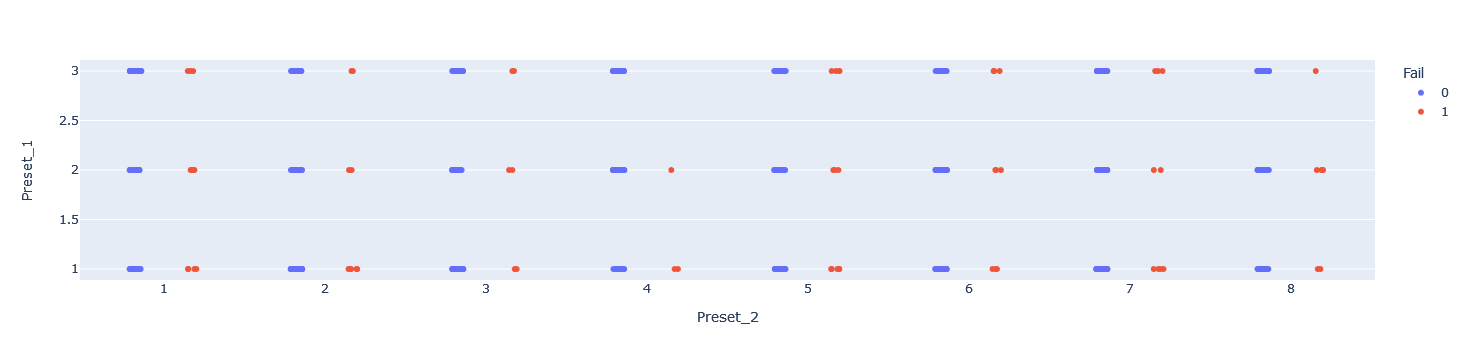

In [166]:
px.strip(y = 'Preset_1', x='Preset_2', color='Fail', data_frame=fpso_df)


- Falhas no equipamento categorizadas pelo tipo de parâmetro

Uma falha dificilmente acontece por um erro de apenas um fator, um problema relacionado a temperatura, pode afetar a pressão que por sua vez pode acarreta em um problema com a vibração. E é o que podemos ver aqui nos dois gráficos seguintes. 

Com o primeiro podemos visualizar que as regiões em que ocorreram falhas no equipamento, estão na mesma faixa para todos os paramêtros, o que confirma a hipótese inicial de que a falha é causada por alterações em diversos fatores.

Podemos notar também que existe relação de distribuição dos dados muito semelhantes para os paramêtros VibrationX e VibrationZ, o que parece indicar que esses fatores possuem uma correlação de moderada a forte entre si, isso fica mais evidenciado pelo segundo gráfico do tipo "violin", em que podemos ver que a dispersão dos dados é quase igual para os dois. 

Ambos os gráficos mostram que os paramêtros presentes no dataset tem um correlação entre si, sendo algumas mais evidentes visualmente. Mais adiante veremos essa correlação de forma mas visual e clara.

In [77]:
param_fpso_df = fpso_df[['Cycle','Temperature', 'Pressure', 'VibrationX','VibrationY', 'VibrationZ','Frequency', 'Fail']]

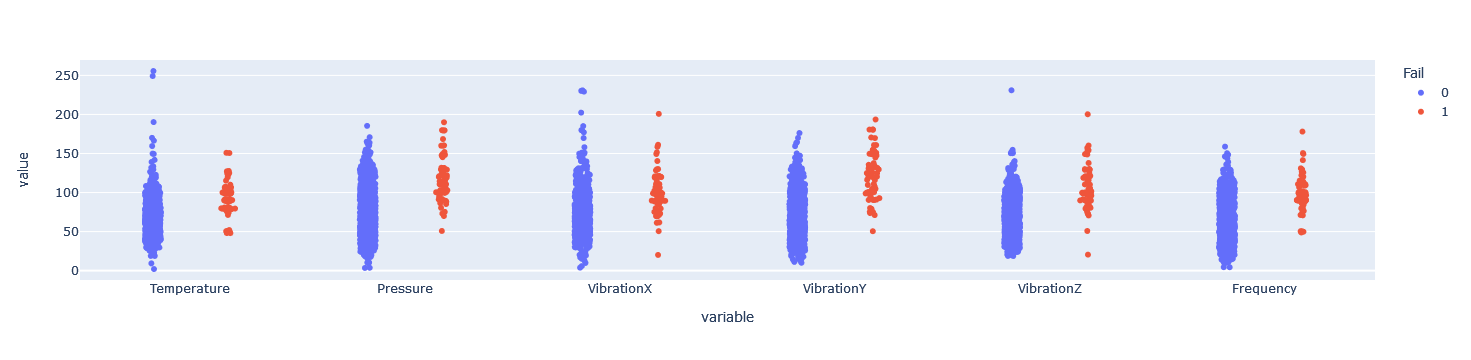

In [168]:
px.strip(data_frame=param_fpso_df.drop('Cycle', axis =1), color='Fail')

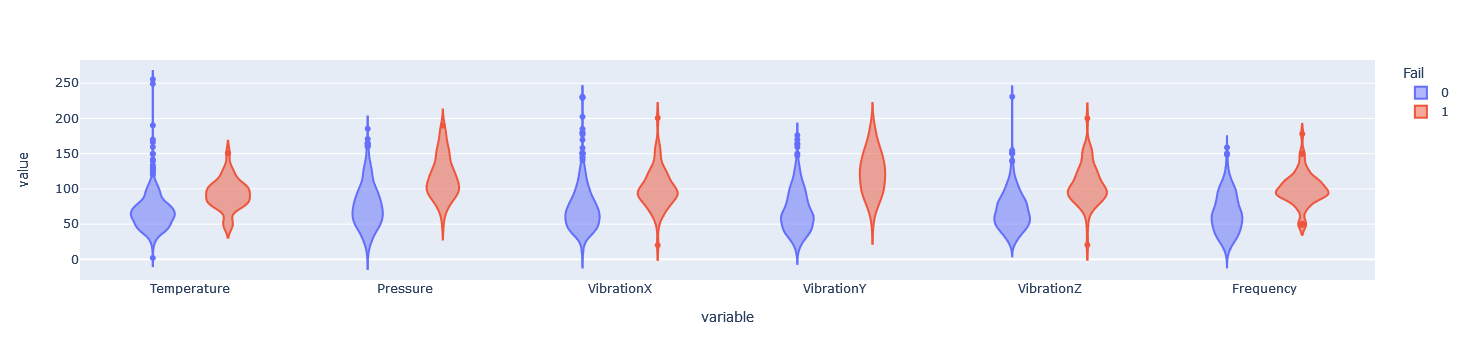

In [184]:
px.violin(data_frame=param_fpso_df.drop('Cycle',axis =1),color='Fail')

Aqui podemos verificar a correlação entre os paramêtros presentes no dataset, e que também já nos dá um indício de algo que veremos quando criarmos o modelo de machine learning, que é a uma visualização dos paramêtros mais importantes para a modelagem dos dados. Por exemplo, podemos ver que o fator que possui maior correlação com a possibilidade de falhas é o VibrationY. Esperamos então que ele seja a feature mais importante na modelagem.

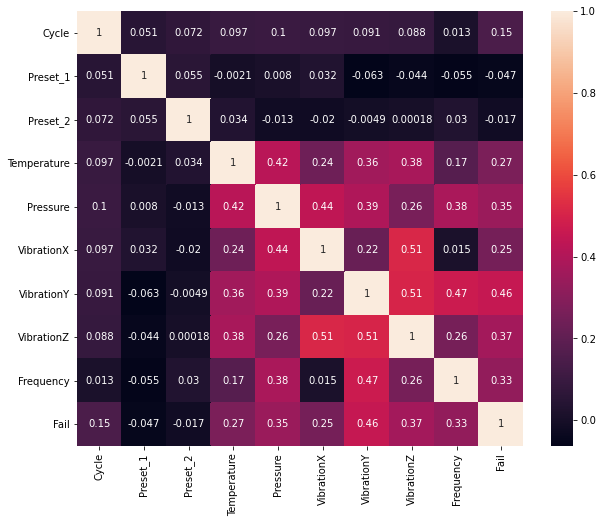

In [34]:
corr = fpso_df.corr()

plt.figure(figsize=(10,8)),
sns.heatmap(corr, annot=True)
plt.show()

# Lidando com desbalanceamento de dados para Machine Learning

Um problema que é encontrado em análises desse tipo, é o fato de falhas serem um acontecimento "mais raro", o que quero dizer com isso, a chance de acontecer uma falha é muito menor do que a chance do equipamento operar normalmente, em condições normais. Se olharmos para a distruição dos valores presentes na coluna de Fail, veremos que as falhas correspondem a menos de 10% dos dados. 

Se utilizarmos um dataset desbalanceadoo para a modelagem, o modelo treinará de forma enviesada e não fará uma predição correta, ele terá uma acurácia alta mas praticamente todos os valores seriam zero, justamente porque a maior probabilidade é realmente de dar zero(Sistema Normal), mas isso não ajudaria a implementar uma manuntenção preventiva que geralmente é o que buscamos nessa situação

In [35]:
X = fpso_df.drop(['Cycle','Fail'], axis = 'columns')
y=fpso_df['Fail']

In [36]:
y.value_counts()

0    734
1     66
Name: Fail, dtype: int64

Uma das técnicas para lidar com esse problema é a de fazer um oversampling, ou seja, aumentamos a quantidade de dados de falha, para que o número de falhas e sucessos no modelo sejam iguais. Aqui fiz a utilização do SMOTE (Synthetic Minority Over-sampling Technique), que se caracteriza por multiplicar os dados minoritários de forma sintética, utilizando para isso os vizinhos próximos dos dados reais, de forma a popular os dados minoritários e assim os dados 0(Normal) e 1(Falha) terão quantidades iguais

In [207]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X,y)

Verificando aqui que realmente temos quantidades iguais de valores 0 e 1 no Dataset

In [44]:
y_sm.value_counts()

0    734
1    734
Name: Fail, dtype: int64

# Machine Learning

## Árvore de Decisão.

A escolha por um modelo utilizando Árvore de Decisão, tem como fundamento o fato de ser um modelo simples que consegue classificar quando temos uma modalidade de desafio de classificação, e sendo esse um caso de classificação binária, optei por fazer seguir com esse modelo. Modelos supervisionados como esse, são bons quando temos um label a ser classificada, nesse caso, Falha ou Não do equipamento. 

Primeiramente separemos a base de dados em variaveis de treino e teste, e em seguida vamos criar o modelo e fazer a previsão dos resultados

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm,
                                                    test_size = 0.3,
                                                    random_state = 42, 
                                                    stratify=y_sm) # Separação em variavéis de treinamento e prova

In [188]:
arvore1 = DecisionTreeClassifier() #Criação do modelo usando o parametro criterion "Gini", que é o padrão Default
arvore1.fit(X_train, y_train)

DecisionTreeClassifier()

In [191]:
previsoes = arvore1.predict(X_test) #Previsão usando os dados de teste


Aqui vamos plotar uma matriz com os erros e acertos do modelo, a matriz tem a seguinte composição 

$
  Matriz = 
  \begin{vmatrix}
    TP & FP\\
    FN & TN
  \end{vmatrix}
 $

Onde TP, FP significa True Positive e False Positive, respectivamente e TN e FN, significam True Negative e False Negative, respectivamente. Ou seja temos uma previsão dos erros e acertos que o modelo cometeu, para o caso do modelo criado, temos:

$
  Matriz = 
  \begin{vmatrix}
    TP(0) = 209 & FP(0) = 12\\
    FN(1) = 5 & TN(1) = 215
  \end{vmatrix}
$,

ou seja de todos os dados utilizados para teste e comparando com o verdadeiro resultado, o modelo acertou 209 como Normais e detectou 215 falhas. O que ao verificarmos a acurácia, veremos que temos uma precisão de 96% de acerto para esse modelo, temos então um modelo que conseguiria nos fornecer dados a respeito da necessidade de uma manutenção preventiva, o que acarreta geralmente em uma economia de recursos financeiros para a empresa

In [192]:
confusao = confusion_matrix(y_test, previsoes)
confusao

array([[209,  12],
       [  5, 215]], dtype=int64)

In [193]:
taxa_acerto = accuracy_score(y_test, previsoes)
taxa_acerto

0.9614512471655329

Vamos agora visualizar a árvore de decisão criada pelo modelo. 

In [194]:
fn = ['Preset_1', 'Preset_2','Temperature', 'Pressure', 'VibrationX','VibrationY', 'VibrationZ','Frequency']
cn = ['Failure','Normal']

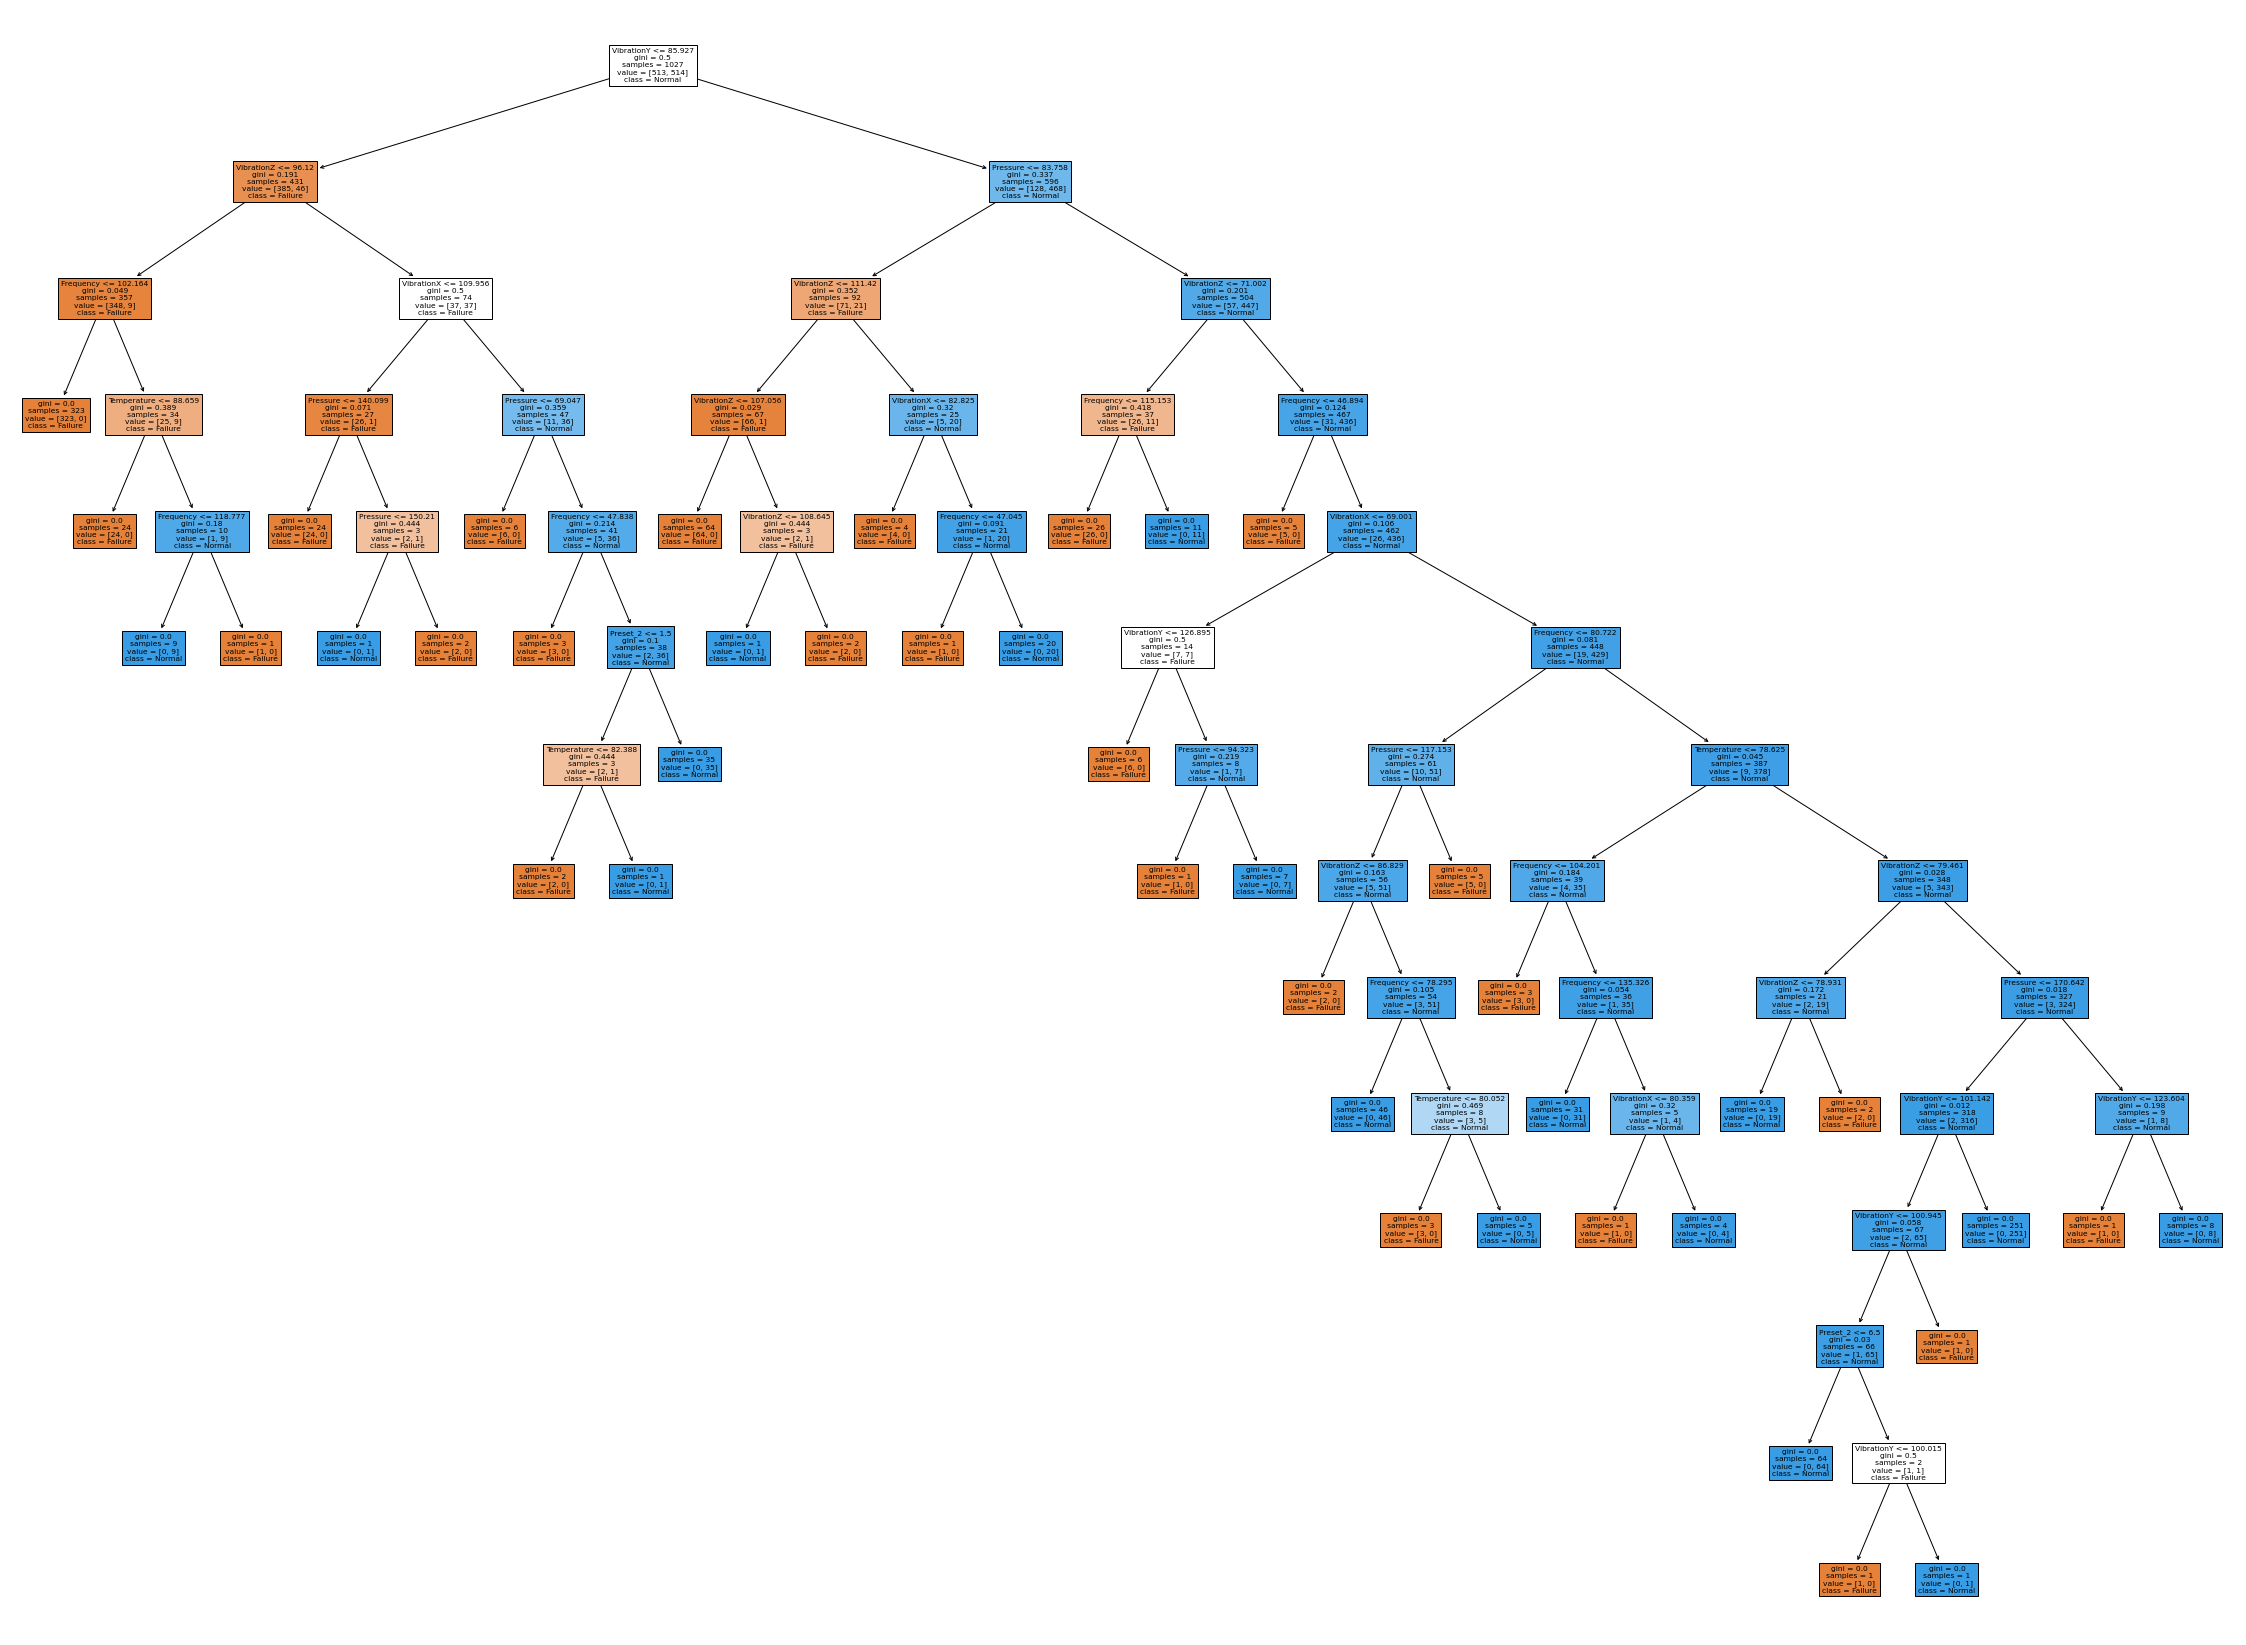

In [196]:
plt.figure(figsize=(40,30))
tree.plot_tree(arvore1,
              feature_names = fn, 
               class_names=cn,
               filled = True)
plt.savefig('arvore_decisao_parameters.png')
plt.show()

In [ ]:
- Análise das variavéis importantes

Podemos ver aqui que como prevemos utilizando a correlação a variavel mais importante para a modelagem é a VibrationY, 

<AxesSubplot:>

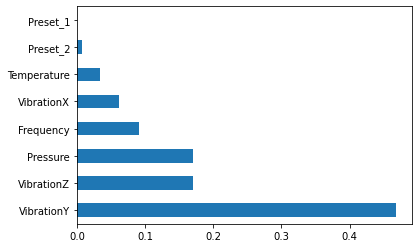

In [198]:
feat_importances = pd.Series(arvore1.feature_importances_, index=X_sm.columns)
feat_importances.nlargest(20).plot(kind='barh')